In [1]:
import numpy as np

import scipy.linalg as la
import scipy.sparse as sparse

from scipy.sparse.linalg import spsolve


import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

# Problem 8
$$ - \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) - e^u = 0$$
Leads to the FD equation
$$4u_{i,j} - u_{i-1,j} - u_{i+1,j} - u_{i,j-1} - u_{i,j+1} - h^2e^{u_{i,j}} = 0$$
for $ 0< i,j < n$
$$f(\vec{u}) = A\vec{u} - e^\vec{u} = 0$$
So the Jacobian is given by the following formulae
$$
\frac{\partial f}{\partial u_{i,j}} = 4 - h^2e^{u_{i,j}}
$$

In [4]:
N = 2**5-1
n = N**2
h = 1/(N+1)

a = .1
iter_max = 10**5
tol = 10**-6


J = np.diag([4]*N) + np.diag([-1]*(N-1),k=-1) + np.diag([-1]*(N-1),k=1)
K = np.diag([-1]*N)
shape_matrix = np.diag([1]*(N-1),k=-1) + np.diag([1]*(N-1),k=1)
A = np.kron(shape_matrix,K) + np.kron(np.eye(N),J)

# generate initial u
X = np.linspace(h,1-h,N)
u = np.array([ a*x*(1-x)*(1-y) for x in X for y in X]).reshape((n,1))

#u = np.ones((n,1))
Jac = A - np.diag(h**2*np.exp(u).ravel())
u_new = u + la.solve(Jac, h**2*np.exp(u) - np.dot(A,u))
for iteration in range(1,iter_max+1):
    if la.norm(u_new-u) < tol*n:
        break
    u = u_new
    Jac = A - np.diag(h**2*np.exp(u).ravel())
    u_new = u + la.solve(Jac, h**2*np.exp(u) - np.dot(A,u))
    
print(iteration)
X, Y = np.meshgrid(np.linspace(h,1-h,N),np.linspace(h,1-h,N))
U = u.reshape((N,N))
plt.pcolormesh(X,Y,U, cmap=cm.coolwarm)

3


In [5]:
#sparse solver
N = 2**7-1
n = N**2
h = 1/(N+1)

a = .1
iter_max = 100
tol = 10**-6


J = np.diag([4]*N) + np.diag([-1]*(N-1),k=-1) + np.diag([-1]*(N-1),k=1)
K = np.diag([-1]*N)
shape_matrix = np.diag([1]*(N-1),k=-1) + np.diag([1]*(N-1),k=1)
A = sparse.lil_matrix(np.kron(shape_matrix,K) + np.kron(np.eye(N),J))

# generate initial u
X = np.linspace(h,1-h,N)
u = np.array([ a*x*(1-x)*(1-y) for x in X for y in X]).reshape((n,1))

#u = np.ones((n,1))
Jac = A - sparse.diags(h**2*np.exp(u).ravel())
u_new = u + spsolve(Jac, h**2*np.exp(u) - A.dot(u)).reshape((n,1))
for iteration in range(1,iter_max+1):
    if la.norm(u_new-u) < tol*n:
        break
    u = u_new
    Jac = A - sparse.diags(h**2*np.exp(u).ravel())
    u_new = u + spsolve(Jac, h**2*np.exp(u) - A.dot(u)).reshape((n,1))
    
u = u_new
    
print(iteration)
X, Y = np.meshgrid(np.linspace(h,1-h,N),np.linspace(h,1-h,N))
U = u.reshape((N,N))
plt.pcolormesh(X,Y,U, cmap=cm.coolwarm)

2


In [333]:
print('scaled norm: %g' % (la.norm(U)/np.sqrt(n)))
print('exp(u) inf norm: %g' % np.max(np.exp(U)))
print('Max height: %g' % np.max(U))

scaled norm: 0.0438569
exp(u) inf norm: 1.08123
Max height: 0.0780975


# Inexact Newton's

In [8]:
def conjugate_gradient(A, b, x_0, tol=10**-2, max_iter=10**3):
    x = x_0
    r = b - A.dot(x)
    delta = np.dot(r.T,r)
    b_delta = np.dot(b.T,b)
    p = r
    for k in range(max_iter):
        if delta < b_delta * tol**2:
            break
        s = A.dot(p)
        alpha = delta/(np.dot(p.T,s))
        x_new = x + p*alpha
        r -= s*alpha
        delta_new = np.dot(r.T,r)
        p = r + p*delta_new/delta
        x, delta = x_new, delta_new
    return x, k

In [14]:
#sparse solver - CG
N = 2**7-1
n = N**2
h = 1/(N+1)
print('n = %d' % n)

a = .5
iter_max = 10**3
tol = 10**-10

cg_iter = 10**10
cg_tol = 10**-2


J = np.diag([4]*N) + np.diag([-1]*(N-1),k=-1) + np.diag([-1]*(N-1),k=1)
K = np.diag([-1]*N)
shape_matrix = np.diag([1]*(N-1),k=-1) + np.diag([1]*(N-1),k=1)
A = sparse.lil_matrix(np.kron(shape_matrix,K) + np.kron(np.eye(N),J))

# generate initial u
X = np.linspace(h,1-h,N)
u = np.array([ a*x*(1-x)*(1-y) for x in X for y in X]).reshape((n,1))

#u = np.ones((n,1))
Jac = A - sparse.diags(h**2*np.exp(u).ravel())
CG, k = conjugate_gradient(Jac, h**2*np.exp(u) - A.dot(u), u, tol=cg_tol, max_iter=cg_iter)
u_new = u + CG.reshape((n,1))
for iteration in range(1,iter_max+1):
    if la.norm(u_new-u) < tol*n:
        break
    u = u_new
    Jac = A - sparse.diags(h**2*np.exp(u).ravel())
    CG, k = conjugate_gradient(Jac, h**2*np.exp(u) - A.dot(u), u, tol=cg_tol, max_iter=cg_iter)
    print('CG iterations: %d' % k)
    u_new = u + CG.reshape((n,1))
    assert u_new.shape==u.shape
    
u = u_new
    
print("Newton's Method iterations: %d" %iteration)
X, Y = np.meshgrid(np.linspace(h,1-h,N),np.linspace(h,1-h,N))
U = u.reshape((N,N))
plt.pcolormesh(X,Y,U, cmap=cm.coolwarm)

n = 16129
CG iterations: 636
CG iterations: 12686
CG iterations: 10589
CG iterations: 13425
Newton's Method iterations: 5


In [10]:
CG

array([[-0.0211174 ],
       [-0.01489606],
       [-0.00988112],
       [-0.00569658],
       [-0.002157  ],
       [ 0.00082619],
       [ 0.00334464],
       [ 0.00540685],
       [ 0.00705324],
       [ 0.00823171],
       [ 0.00892419],
       [ 0.00909968],
       [ 0.00857983],
       [ 0.0071904 ],
       [ 0.0046003 ],
       [-0.04052652],
       [-0.02911966],
       [-0.01969196],
       [-0.01175391],
       [-0.00505103],
       [ 0.00061439],
       [ 0.00535356],
       [ 0.00922543],
       [ 0.01227136],
       [ 0.01441328],
       [ 0.01562719],
       [ 0.01584012],
       [ 0.01475916],
       [ 0.01211724],
       [ 0.00746834],
       [-0.05747689],
       [-0.04189894],
       [-0.02878247],
       [-0.01766639],
       [-0.00820681],
       [-0.00026509],
       [ 0.00641066],
       [ 0.01178691],
       [ 0.0160162 ],
       [ 0.01893789],
       [ 0.02052684],
       [ 0.02074277],
       [ 0.01916671],
       [ 0.01551474],
       [ 0.0093778 ],
       [-0

In [ ]:
print('scaled norm: %g' % (la.norm(U)/np.sqrt(n)))
print('exp(u) inf norm: %g' % np.max(np.exp(U)))

In [6]:
def sparse_solver_CG(N, a, tol=10**-10):
    n = N**2
    h = 1/(N+1)

    iter_max = 10**3
    #tol = 10**-6

    cg_iter = 10**10
    cg_tol = 10**-2


    J = np.diag([4]*N) + np.diag([-1]*(N-1),k=-1) + np.diag([-1]*(N-1),k=1)
    K = np.diag([-1]*N)
    shape_matrix = np.diag([1]*(N-1),k=-1) + np.diag([1]*(N-1),k=1)
    A = sparse.lil_matrix(np.kron(shape_matrix,K) + np.kron(np.eye(N),J))

    # generate initial u
    X = np.linspace(h,1-h,N)
    u = np.array([ a*x*y*(1-x)*(1-y) for x in X for y in X]).reshape((n,1))

    #u = np.ones((n,1))
    Jac = A - sparse.diags(h**2*np.exp(u).ravel())
    u_new = u + conjugate_gradient(Jac, h**2*np.exp(u) - A.dot(u), u, tol=cg_tol, max_iter=cg_iter)[0].reshape((n,1))
    for iteration in range(1,iter_max+1):
        if la.norm(u_new-u) < tol*n:
            break
        u = u_new
        Jac = A - sparse.diags(h**2*np.exp(u).ravel())
        u_new = u + conjugate_gradient(Jac, h**2*np.exp(u) - A.dot(u), u, tol=cg_tol, max_iter=cg_iter)[0].reshape((n,1))
        assert u_new.shape==u.shape

    return u_new

a=0.010000, diff=5.11351e-11
a=0.161414, diff=4.55864e-11
a=0.312828, diff=1.22126e-10
a=0.464242, diff=1.54239e-10
a=0.615657, diff=2.32685e-10
a=0.767071, diff=3.47022e-10
a=0.918485, diff=8.73686e-10
a=1.069899, diff=9.94018e-10
a=1.221313, diff=1.05314e-09
a=1.372727, diff=1.0814e-09
a=1.524141, diff=1.07262e-09
a=1.675556, diff=1.04245e-09
a=1.826970, diff=9.52468e-10
a=1.978384, diff=8.19966e-10
a=2.129798, diff=3.12253e-10
a=2.281212, diff=2.32689e-10
a=2.432626, diff=1.54238e-10
a=2.584040, diff=8.61068e-11
a=2.735455, diff=4.55893e-11
a=2.886869, diff=3.58598e-15
a=3.038283, diff=1.48147e-09
a=3.189697, diff=1.52388e-09
a=3.341111, diff=1.29046e-09
a=3.492525, diff=1.29022e-09
a=3.643939, diff=1.28994e-09
a=3.795354, diff=1.28962e-09
a=3.946768, diff=1.28927e-09
a=4.098182, diff=1.28886e-09
a=4.249596, diff=1.28842e-09
a=4.401010, diff=1.28842e-09
a=4.552424, diff=1.16294e-09
a=4.703838, diff=1.16294e-09
a=4.855253, diff=1.16294e-09
a=5.006667, diff=1.16236e-09
a=5.158081, dif

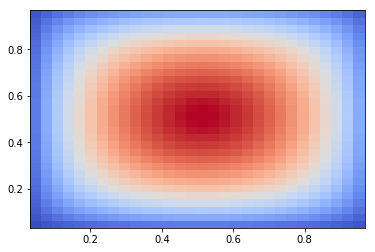

In [190]:
N = 2**5-1
n = N**2

u = sparse_solver_CG(N,.1)
for a in np.linspace(0.01,15,100):
    u_0 = np.random.randn(n)
    u_new = sparse_solver_CG(N,a)
    print('a=%f, diff=%g' % (a,la.norm(u - u_new)) )
    if la.norm(u - u_new) > 10**-2:
        break

print(iteration)
X, Y = np.meshgrid(np.linspace(h,1-h,N),np.linspace(h,1-h,N))
U = u.reshape((N,N))
plt.pcolormesh(X,Y,U, cmap=cm.coolwarm)
U = u_new.reshape((N,N))
plt.pcolormesh(X,Y,U, cmap=cm.coolwarm)

In [159]:
type(a)==type(None)

True

In [162]:
np.random.randn(3)

array([ 0.74670865, -0.32621265,  0.29148272])

# Problem 15

In [2]:
def goo(gamma1, gamma2, t):
    return gamma1*np.exp(gamma2*t)

goo = np.vectorize(goo)

In [3]:
t = np.array([[0],[1],[2]])
z = np.exp(np.array([[.1],[.9],[2]]))

gamma = np.ones((2,1))
gamma1 = gamma[0,0]
gamma2 = gamma[1,0]

g = goo(gamma1, gamma2, t)
A = np.zeros((3,2))
A[:,0:1] = np.exp(gamma2*t)
A[:,1:2] = gamma1*t*np.exp(gamma2*t)

for i in range(1,100):
    p = la.lstsq(A,z-g)[0]
    if la.norm(p) < 10**-15:
        print(gamma)
        print(i)
        break
    gamma += p
    gamma1 = gamma[0,0]
    gamma2 = gamma[1,0]
    g = goo(gamma1, gamma2, t)
    A = np.zeros((3,2))
    A[:,0:1] = np.exp(gamma2*t)
    A[:,1:2] = gamma1*t*np.exp(gamma2*t)

[[0.9138539 ]
 [1.04343342]]
12


In [4]:
def my_solve(gamma, tol, max_iter=200):
    t = np.array([[0],[1],[2]])
    z = np.exp(np.array([[.1],[.9],[2]]))

    gamma = np.array(gamma).reshape((2,1))
    gamma1 = gamma[0,0]
    gamma2 = gamma[1,0]

    g = goo(gamma1, gamma2, t)
    A = np.zeros((3,2))
    A[:,0:1] = np.exp(gamma2*t)
    A[:,1:2] = gamma1*t*np.exp(gamma2*t)

    for i in range(1,max_iter+1):
        p = la.lstsq(A,z-g)[0]
        if la.norm(p) < tol*(la.norm(gamma)+1):
            break
        gamma += p
        gamma1 = gamma[0,0]
        gamma2 = gamma[1,0]
        g = goo(gamma1, gamma2, t)
        A = np.zeros((3,2))
        A[:,0:1] = np.exp(gamma2*t)
        A[:,1:2] = gamma1*t*np.exp(gamma2*t)
    
    return gamma, i

In [5]:
gamma_0 , k = my_solve([1.0,1.0], 10**-10)
gamma_1, k = my_solve([.05,.25], 10**-10)

In [7]:
print(k)

7


In [13]:
gamma_0

array([[0.9138539 ],
       [1.04343342]])

In [12]:
%matplotlib qt
xs = np.linspace(0, 2, 50)
ys = np.linspace(0, .4, 50)
X, Y = np.meshgrid(xs, ys)
U = []
for x in xs:
    for y in ys:
        u = 0
        try:
            gamma, k = my_solve([x,y], 10**-10)
            if la.norm(gamma_0 - gamma) > .001:
                if la.norm(gamma_1 - gamma) > .001:
                    u = 1
                else:
                    u = 2
        except ValueError:
            u = -1       
        U += [u]
U = np.array(U).reshape(X.shape)
plt.pcolormesh(X,Y,U, cmap=cm.coolwarm)
plt.xlabel('gamma_1')
plt.ylabel('gamma_2')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp


Text(0,0.5,'gamma_2')

In [8]:
gamma_1

array([[4.85934501e-15],
       [3.63891672e+01]])

In [11]:
%matplotlib qt
max_iter = 200
xs = np.linspace(0, 2, 100)
ys = np.linspace(0, 1,100)
X, Y = np.meshgrid(xs, ys)
U = []
for x in xs:
    for y in ys:
        u = 0
        try:
            gamma, u = my_solve([x,y], 10**-10, max_iter=max_iter)
        except ValueError:
            u = 0     
        U += [u]
U = np.array(U).reshape(X.shape)
plt.pcolormesh(X,Y,U, cmap=cm.coolwarm)
plt.xlabel('gamma_1')
plt.ylabel('gamma_2')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp


Text(0,0.5,'gamma_2')

In [10]:
print(np.max(U), np.min(U))

38 0


0.23522625573357414


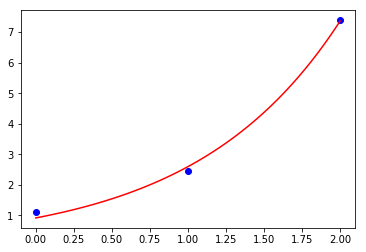

In [11]:
gamma = gamma_0.ravel()
plt.plot(t,z,'bo')
ts = np.linspace(0,2,100)
plt.plot(ts, gamma[0]*np.exp(gamma[1]*ts),'r-')
print(la.norm(z - gamma[0]*np.exp(gamma[1]*t)))

1.967011005363156e+17


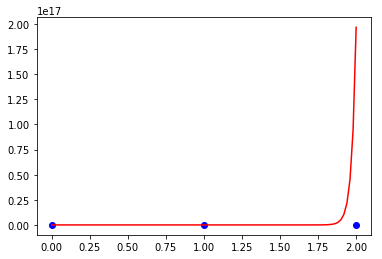

In [12]:
gamma = gamma_1.ravel()
plt.plot(t,z,'bo')
ts = np.linspace(0,2,100)
plt.plot(ts, gamma[0]*np.exp(gamma[1]*ts),'r-')
print(la.norm(z - gamma[0]*np.exp(gamma[1]*t)))

In [13]:
gamma_1.ravel()

array([4.85934501e-15, 3.63891672e+01])

In [14]:
z

array([[1.10517092],
       [2.45960311],
       [7.3890561 ]])

In [15]:
gamma

array([4.85934501e-15, 3.63891672e+01])

In [16]:
gamma[0]

4.85934500916909e-15

In [17]:
gamma[1]

36.389167226572916

In [9]:
%matplotlib qt
A = np.array([[1, 0],[1,1],[1,2]])
b = np.array([[.1],[.9],[2]])
x = np.linalg.lstsq(A,b)[0]
print(A)
print(b)
print(x)

g1 = np.exp(x[0])
g2 = x[1]

gamma_6 = np.array([g1,g2]).reshape((2,1))

print('gamma_1 = {}'.format(g1))
print('gamma_2 = {}'.format(g2))

ts = np.linspace(-.1,2.1,1000)
us = g1*np.exp(g2*ts)

plt.plot([0,1,2], np.exp(b), 'go', label='Data')
plt.plot(ts, us, 'b-', label='Linear Regression')

gamma = gamma_0.ravel()
#ts = np.linspace(0,2,100)
plt.plot(ts, gamma[0]*np.exp(gamma[1]*ts),'r-', label='Non-Linear Regression')
print(la.norm(z - gamma[0]*np.exp(gamma[1]*t)))


plt.legend()
plt.xlabel('t')
plt.ylabel('z')

plt.show()

[[1 0]
 [1 1]
 [1 2]]
[[0.1]
 [0.9]
 [2. ]]
[[0.05]
 [0.95]]
gamma_1 = [1.0512711]
gamma_2 = [0.95]
0.23522625573357414


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


In [10]:
gamma_0

array([[0.9138539 ],
       [1.04343342]])

In [12]:
max_iter = 200
print(my_solve(gamma_6, 10**-10, max_iter=max_iter))

(array([[0.9138539 ],
       [1.04343342]]), 8)


In [13]:
%matplotlib qt
plt.plot(t, z - gamma_0[0]*np.exp(gamma_0[1]*t), 'ro', label='Non-Linear Residual')
plt.plot(t, z - gamma_6[0]*np.exp(gamma_6[1]*t), 'bo', label='Linear Residual')
plt.legend()
plt.xlabel('t')
plt.ylabel('residual')
print(la.norm(z - gamma_0[0]*np.exp(gamma_0[1]*t)))
print(la.norm(z - gamma_6[0]*np.exp(gamma_6[1]*t)))

0.23522625573357414
0.4468616548506424
